# MadMiner tutorial 1: From cards to likelihood ratios

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In this tutorial we'll introduce the basic MadMiner workflow. We'll show you how to use MadMiner to generate events, extract training data, and train neural networks to estimate likelihood ratios.

This tutorial does not try to explain the inference methods. To understand what MadMiner is doing, please have a look at some papers first. In
["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013)
we explain the basic idea of most of the methods presented here, while ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020) is an extensive 65-page handbook going through the details.

## 0. Preparations

Before you execute this notebook, make sure you have running installations of MadGraph, Pythia, and Delphes. Note that at least for now, the MG-Pythia interface and Delphes require custom patches (available upon request). In addition, MadMiner has to be in your PYTHONPATH.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
% matplotlib inline

from madminer.core import MadMiner
from madminer.plotting import plot_2d_morphing_basis
from madminer.delphes import DelphesProcessor
from madminer.sampling import combine_and_shuffle
from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge


Please enter here the path to your MG5 root directory. This notebook assumes that you installed Delphes and Pythia through MG5.

In [2]:
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2'

## 1. Define parameter space

After creating a `GoldMine` instance, the first important step is the definition of the parameter space. Each model parameter is characterized by a name as well as the LHA block and ID.

If morphing is used, one also has to specify the maximal power with which the parameter contributes to the squared matrix element. For instance, a parameter that contributes only to one vertex, will typically have `morphing_max_power=2`, while a parameter that contributes to two vertices usually has `morphing_max_power=4`. Exceptions arise for instance when the interference effects between the SM and dimension-six operators are modelled, but the square of the dimension-six amplitude (subleading in 1/Lambda) is not taken into account, in which case `morphing_max_power=1`. The `parameter_range` argument defines the range of parameter values that are used for the automatic optimization of the morphing basis.

Finally, the parameter values theta used internally by MadMiner and the parameter values written to the param_card (or reweight_card) given to MadGraph do not have to be exactly the same. With the option `parm_card_transform`, the user can supply a one-parameter function that maps a parameter value theta to the value given to MadGraph. This string is a python expression, in which `theta` is parsed as the parameter value. For instance, if the internal parameters are in the range (0, 1), but should be linearly scaled to (0, 100) in the param_card, one would have to use `param_card_transform="100*theta"`.

In [3]:
miner = MadMiner(debug=False)

miner.add_parameter(
    lha_block='dim6',
    lha_id=2,
    parameter_name='CWL2',
    morphing_max_power=2,
    param_card_transform="16.52*theta",
    parameter_range=(-1.,1.)
)
miner.add_parameter(
    lha_block='dim6',
    lha_id=5,
    parameter_name='CPWL2',
    morphing_max_power=2,
    param_card_transform="16.52*theta",
    parameter_range=(-1.,1.)
)

17:33  
17:33  ------------------------------------------------------------
17:33  |                                                          |
17:33  |  MadMiner v2018.10.24                                    |
17:33  |                                                          |
17:33  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
17:33  |                                                          |
17:33  ------------------------------------------------------------
17:33  
17:33  Added parameter CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-1.0, 1.0))
17:33  Added parameter CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-1.0, 1.0))


## 2. Define benchmark points (evaluation points for |M|^2)

The next step is the definition of all the points at which the weights (squared matrix elements) should be evaluated by MadGraph. We call these points "benchmarks".

### 2a. Set benchmarks by hand

One can define benchmarks by hand:

In [4]:
miner.add_benchmark(
    {'CWL2':0., 'CPWL2':0.},
    'sm'
)
miner.add_benchmark(
    {'CWL2':1., 'CPWL2':0.},
    'w'
)

17:33  Added benchmark sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00)
17:33  Added benchmark w: CWL2 = 1.00, CPWL2 = 0.00e+00)


### 2b. Benchmarks for morphing

If morphing is used, the function `set_benchmarks_from_morphing` has to be called. With the option `keep_existing_benchmarks=True`, MadMiner will keep all the benchmark points defined beforehand and run a simple optimization algorithm to fix the remaining ones for the basis (which may be none). Otherwise, MadMiner will optimize the full basis and forget about all previously defined benchmark points. The argument `n_trials` determines the number of random candidate bases that the optimization algorithm goes through.

In [5]:
miner.set_benchmarks_from_morphing(
    keep_existing_benchmarks=True,
    n_trials=1000,
    max_overall_power=2
)

17:33  Optimizing basis for morphing
17:33  Added benchmark sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00)
17:33  Added benchmark w: CWL2 = 1.00, CPWL2 = 0.00e+00)
17:33  Added benchmark morphing_basis_vector_2: CWL2 = 0.71, CPWL2 = -6.50e-01)
17:33  Added benchmark morphing_basis_vector_3: CWL2 = -6.97e-01, CPWL2 = 0.70)
17:33  Added benchmark morphing_basis_vector_4: CWL2 = -8.98e-01, CPWL2 = -5.24e-01)
17:33  Added benchmark morphing_basis_vector_5: CWL2 = 0.70, CPWL2 = 0.93)


Let's have a look at the resulting morphing basis and the "morphing error", i.e. the sum of squared morphing weights as a function of the parameter space:

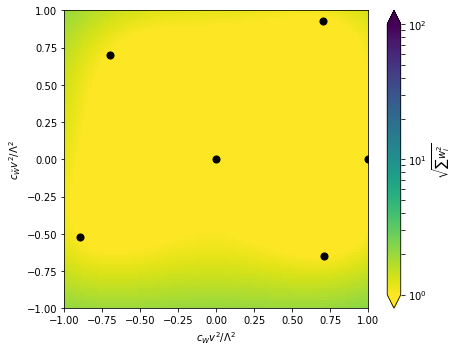

In [6]:
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$c_{W} v^2 / \Lambda^2$',
    ylabel=r'$c_{\tilde{W}} v^2 / \Lambda^2$',
    xrange=(-1.,1),
    yrange=(-1.,1.)
)

## 3. Save settings and run MadGraph

The parameter space, benchmark points, and morphing setup are saved in a HDF5 file:

In [7]:
miner.save('data/madminer_example.h5')

17:33  Saving setup (including morphing) to data/madminer_example.h5


They can now be loaded again with `miner.load(filename)`.

In a next step, MadMiner starts MadGraph and Pythia to generate events and calculate the weights. You have to provide paths to the process card, run card, param card (the entries corresponding to the parameters of interest will be automatically adapted), and an empty reweight card. Log files in the `log_directory` folder collect the MadGraph output and are important for debugging.

The `sample_benchmark` option can be used to specify which benchmark should be used for sampling. If it is not used, MadMiner will automatically use the benchmark that was added first.

Finally, if MadGraph is supposed to run in a different Python environment or requires other setup steps, you can use the `initial_command` argument.

In [9]:
miner.run(
    sample_benchmark='sm',
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/signal',
    proc_card_file='cards/proc_card_signal.dat',
    param_card_template_file='cards/param_card_template.dat',
    reweight_card_template_file='cards/reweight_card_template.dat',
    run_card_file='cards/run_card.dat',
    pythia8_card_file='cards/pythia8_card.dat',
    log_directory='logs/signal',
    initial_command='source activate python2'
)

17:34  Generating MadGraph process folder from cards/proc_card_signal.dat at ./mg_processes/signal
17:34  Run 0
17:34    Sampling from benchmark: sm
17:34    Original run card:       cards/run_card.dat
17:34    Original Pythia8 card:   cards/run_card.dat
17:34    Copied run card:         ./mg_processes/signal/madminer/cards/run_card_0.dat
17:34    Copied Pythia8 card:     ./mg_processes/signal/madminer/cards/pythia8_card_0.dat
17:34    Param card:              ./mg_processes/signal/madminer/cards/param_card_0.dat
17:34    Reweight card:           ./mg_processes/signal/madminer/cards/reweight_card_0.dat
17:34    Log file:                logs/signal/run_0.log
17:34  Creating param and reweight cards in ./mg_processes/signal/madminer/cards/param_card_0.dat, ./mg_processes/signal/madminer/cards/reweight_card_0.dat
17:34  Starting MadGraph and Pythia in ./mg_processes/signal


It is possible to start multiple processes based on the same `MadMiner` instance. This can be used to combine samples sampled according to different benchmarks, and to add reducible backgrounds. 

For the latter, a useful option is the `is_background` switch, which should be used for processes that do *not* depend on the parameters theta. `is_background=True` will disable the reweighting and re-use the same weights for all cross sections.

In [10]:
miner.run(
    is_background=True,
    sample_benchmark='sm',
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/background',
    proc_card_file='cards/proc_card_background.dat',
    param_card_template_file='cards/param_card_template.dat',
    reweight_card_template_file='cards/reweight_card_template.dat',
    run_card_file='cards/run_card.dat',
    pythia8_card_file='cards/pythia8_card.dat',
    log_directory='logs/background',
    initial_command='source activate python2'
)

18:01  Generating MadGraph process folder from cards/proc_card_background.dat at ./mg_processes/background
18:01  Run 0
18:01    Sampling from benchmark: sm
18:01    Original run card:       cards/run_card.dat
18:01    Original Pythia8 card:   cards/run_card.dat
18:01    Copied run card:         ./mg_processes/background/madminer/cards/run_card_0.dat
18:01    Copied Pythia8 card:     ./mg_processes/background/madminer/cards/pythia8_card_0.dat
18:01    Param card:              ./mg_processes/background/madminer/cards/param_card_0.dat
18:01    Reweight card:           ./mg_processes/background/madminer/cards/reweight_card_0.dat
18:01    Log file:                logs/background/run_0.log
18:01  Creating param and reweight cards in ./mg_processes/background/madminer/cards/param_card_0.dat, ./mg_processes/background/madminer/cards/reweight_card_0.dat
18:01  Starting MadGraph and Pythia in ./mg_processes/background


Finally, two options might be very useful for larger projects:
- `MadMiner.run_multiple()` allows you to start multiple runs with different run cards or different choices of `sample_benchmark`.
- Both `MadMiner.run()` and `MadMiner.run_multiple()` have a `only_create_script` keyword. If that is set to True, MadMiner will not start the event generation directly, but prepare folders with all the right settings and ready-to-run bash scripts. This might make it much easier to generate Events on a high-performance computing system. 

## 4. Run detector simulation and extract observables

The `madminer.delphes` wraps around Delphes, a popular fast detector simulation. In addition to simulating the detector, it allows for the fast extraction of observables, which are saved in the MadMiner HDF5 file. The central object is an instance of the `DelphesProcessor` class, which has to be initialized with a MadMiner file:

In [11]:
dp = DelphesProcessor('data/madminer_example.h5')

After creating the DelphesProcessor object, one can add a number of HepMC event samples (the output of running MadGraph and Pythia in step 3) and have it run Delphes:

In [12]:
dp.add_hepmc_sample(
    'mg_processes/signal/Events/run_01/tag_1_pythia8_events.hepmc.gz',
    sampled_from_benchmark='sm'
)
dp.add_hepmc_sample(
    'mg_processes/background/Events/run_01/tag_1_pythia8_events.hepmc.gz',
    sampled_from_benchmark='sm'
)

dp.run_delphes(
    delphes_directory=mg_dir + '/Delphes',
    delphes_card='cards/delphes_card.dat',
    log_directory='logs',
    initial_command='source activate python2'
)

12:10  Adding HepMC sample at mg_processes/signal/Events/run_01/tag_1_pythia8_events.hepmc.gz
12:10  Adding HepMC sample at mg_processes/background/Events/run_01/tag_1_pythia8_events.hepmc.gz
12:11  Running Delphes (/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2/Delphes) on event sample at mg_processes/signal/Events/run_01/tag_1_pythia8_events.hepmc.gz
12:17  Running Delphes (/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2/Delphes) on event sample at mg_processes/background/Events/run_01/tag_1_pythia8_events.hepmc.gz


The next step is the definition of observables through a name and a python expression. For the latter, you can use the objects `j[i]`, `e[i]`, `mu[i]`, `a[i]`, `met`, where the indices `i` refer to a ordering by the transverse momentum. All of these objects inherit from scikit-hep [LorentzVectors](http://scikit-hep.org/api/math.html#vector-classes), see the link for a documentation of their properties. In addition, they have `charge` and `pdg_id` properties.

There is an optional keyword `required`. If `required=True`, we will only keep events where the observable can be parsed, i.e. all involved particles have been detected. If `required=False`, un-parseable observables will be filled with the value of another keyword `default`.

In [13]:
dp.add_observable('pt_j1', 'j[0].pt', required=True)
dp.add_observable('delta_phi_jj', 'abs(j[0].phi() - j[1].phi())', required=True)

We can also add cuts, again in parse-able strings. In addition to the objects discussed above, they can contain the observables:

In [14]:
dp.add_cut('pt_j1 > 20.')
dp.add_cut('(j[0] + j[1]).m > 500.')

14:19  Adding cut pt_j1 > 20.
14:19  Adding cut (j[0] + j[1]).m > 500.


The function `analyse_delphes_samples` then calculates all observables from the Delphes ROOT file(s) generated before and applies the cuts:

In [15]:
dp.analyse_delphes_samples()

14:19  Analysing Delphes sample mg_processes/signal/Events/run_01/tag_1_pythia8_events_delphes.root
14:20  Requiring existence of observable pt_j1: 99668 events pass, 332 events removed
14:20  Requiring existence of observable delta_phi_jj: 93000 events pass, 7000 events removed
14:20  Cut pt_j1 > 20.: 99668 events pass, 332 events removed
14:20  Cut (j[0] + j[1]).m > 500.: 48036 events pass, 51964 events removed
14:20  Analysing Delphes sample mg_processes/background/Events/run_01/tag_1_pythia8_events_delphes.root
14:21  Requiring existence of observable pt_j1: 99379 events pass, 621 events removed
14:21  Requiring existence of observable delta_phi_jj: 91937 events pass, 8063 events removed
14:21  Cut pt_j1 > 20.: 99379 events pass, 621 events removed
14:21  Cut (j[0] + j[1]).m > 500.: 17794 events pass, 82206 events removed


The values of the observables and the weights are then saved in the HDF5 file. It is possible to overwrite the same file, or to leave the original file intact and save all the data into a new file as follows:

In [16]:
dp.save('data/madminer_example_with_data.h5')

14:21  Loading HDF5 data from data/madminer_example.h5 and saving file to data/madminer_example_with_data.h5


It's easy to check some (normalized) distributions at this stage

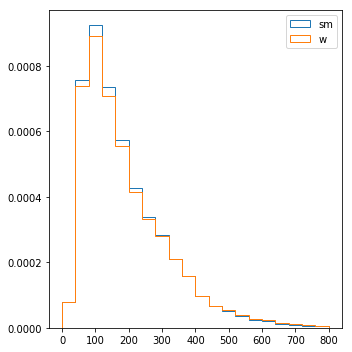

In [17]:
fig = plt.figure(figsize=(5,5))

for label in ['sm', 'w']:
    plt.hist(
        dp.observations['pt_j1'],
        range=(0.,800.),
        bins=20,
        histtype='step',
        weights=dp.weights[label],
        label=label
    )
    
plt.legend()

plt.tight_layout()
plt.show()

One side remark: For the detector simulation and calculation of observables, different users might have very different requirements. While a phenomenologist might be content with the fast detector simulation from Delphes, an experimental analysis might require the full simulation through Geant4. We therefore intend this part to be interchangeable.

## 5. Combine and shuffle different event samples

To reduce disk usage, you can generate several small event samples with the steps given above, and combine them now. Note that (for now) it is essential that all of them are generated with the same setup, including the same benchmark points / morphing basis!

In our case we only have one sample, so this is not strictly necessary, but we still include it for completeness.

In [18]:
combine_and_shuffle(
    ['data/madminer_example_with_data.h5'],
    'data/madminer_example_shuffled.h5'
)

14:21  Copying setup from data/madminer_example_with_data.h5 to data/madminer_example_shuffled.h5
14:21  Loading samples from file 1 / 1 at data/madminer_example_with_data.h5


## 6. Make (unweighted) training and test samples with augmented data

The next step is handled by the `madminer.sampling` class `SampleAugmenter`. From all the data we have in the MadMiner file now, it extracts unweighted samples including the augmented data ("gold") that is needed as training and evaluation data for the machine learning algorithms.

In [19]:
sa = SampleAugmenter('data/madminer_example_shuffled.h5', debug=False)

14:21  Loading data from data/madminer_example_shuffled.h5
14:21  Found 2 parameters:
14:21     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-1.0, 1.0))
14:21     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-1.0, 1.0))
14:21  Found 6 benchmarks:
14:21     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
14:21     w: CWL2 = 1.00, CPWL2 = 0.00e+00
14:21     morphing_basis_vector_2: CWL2 = 0.71, CPWL2 = -6.50e-01
14:21     morphing_basis_vector_3: CWL2 = -6.97e-01, CPWL2 = 0.70
14:21     morphing_basis_vector_4: CWL2 = -8.98e-01, CPWL2 = -5.24e-01
14:21     morphing_basis_vector_5: CWL2 = 0.70, CPWL2 = 0.93
14:21  Found 2 observables: pt_j1, delta_phi_jj
14:21  Found 65830 events
14:21  Found morphing setup with 6 components


The `SampleAugmenter` class defines five different high-level functions to generate train or test samples:
- `extract_samples_train_plain()`, which only saves observations x, for instance for histograms or ABC;
- `extract_samples_train_local()` for methods like SALLY and SALLINO, which will be demonstrated in the second part of the tutorial;
- `extract_samples_train_ratio()` for techniques like CARL, ROLR, CASCAL, and RASCAL, when only theta0 is parameterized;
- `extract_samples_train_more_ratios()` for the same techniques, but with both theta0 and theta1 parameterized;
- `extract_samples_test()` for the evaluation of any method.

For the arguments `theta`, `theta0`, or `theta1`, you can use the helper functions `constant_benchmark_theta()`, `multiple_benchmark_thetas()`, `constant_morphing_theta()`, `multiple_morphing_thetas()`, and `random_morphing_thetas()`, all defined in the `madminer.sampling` module.

Here we'll train a likelihood ratio estimator with the RASCAL method, so we focus on the `extract_samples_train_ratio()` function.

In [43]:
x, theta0, theta1, y, r_xz, t_xz = sa.extract_samples_train_ratio(
    theta0=random_morphing_thetas(100, [('gaussian', 0., 0.5), ('gaussian', 0., 0.5)]),
    theta1=constant_benchmark_theta('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='train1'
)

15:42  Extracting training sample for ratio-based methods. Numerator hypothesis: ('random', (100, [('gaussian', 0.0, 0.5), ('gaussian', 0.0, 0.5)])), denominator hypothesis: ('benchmark', 'sm')
15:42  Effective number of samples: mean 3773.134556718892, with individual thetas ranging from 216.99855773930938 to 9979.813091727277
15:42  Effective number of samples: mean 9929.624393271837, with individual thetas ranging from 9929.624393271837 to 9929.624393271837


For the evaluation we'll need a test sample, and we'll make two just for fun:

In [44]:
x, theta = sa.extract_samples_test(
    theta=constant_benchmark_theta('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='test'
)

x_bsm, theta_bsm = sa.extract_samples_test(
    theta=constant_benchmark_theta('w'),
    n_samples=100000,
    folder='./data/samples',
    filename='test_bsm'
)

15:42  Extracting evaluation sample. Sampling according to ('benchmark', 'sm')
15:42  Effective number of samples: 5937.758055009709
15:42  Extracting evaluation sample. Sampling according to ('benchmark', 'w')
15:42  Effective number of samples: 243.2510753637643


Let's have a look at some distributions and correlations between these two samples:

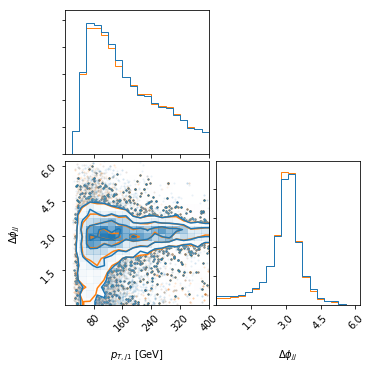

In [45]:
import corner

labels = [r'$p_{T,j1}$ [GeV]', r'$\Delta \phi_{jj}$']
ranges = [(0., 400.), (0.,6.2)]

fig = corner.corner(x_bsm, color='C1', labels=labels, range=ranges)
_ = corner.corner(x, color='C0', labels=labels, range=ranges, fig=fig)

We can also calculate total cross sections:

In [46]:
thetas_benchmarks, xsecs_benchmarks, xsec_errors_benchmarks = sa.extract_cross_sections(
    theta=multiple_benchmark_thetas(['sm', 'w', 'morphing_basis_vector_2', 'morphing_basis_vector_3', 'morphing_basis_vector_4', 'morphing_basis_vector_5'])
)

thetas_morphing, xsecs_morphing, xsec_errors_morphing = sa.extract_cross_sections(
    theta=random_morphing_thetas(1000, [('gaussian', 0., 0.5), ('gaussian', 0., 0.5)])
)

15:43  Starting cross-section calculation
15:43  Starting cross-section calculation


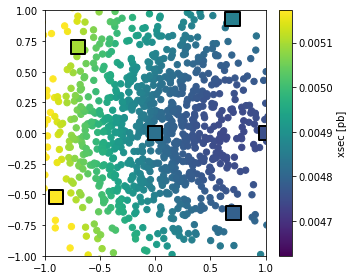

In [47]:
cmin, cmax = np.mean(xsecs_morphing) - 2 * np.std(xsecs_morphing), np.mean(xsecs_morphing) + 2 * np.std(xsecs_morphing)

fig = plt.figure(figsize=(5,4))

sc = plt.scatter(thetas_morphing[:,0], thetas_morphing[:,1], c=xsecs_morphing,
            s=40., cmap='viridis', vmin=cmin, vmax=cmax,
            marker='o')

plt.scatter(thetas_benchmarks[:,0], thetas_benchmarks[:,1], c=xsecs_benchmarks,
            s=200., cmap='viridis', vmin=cmin, vmax=cmax, lw=2., edgecolor='black',
            marker='s')

cb = plt.colorbar(sc)
cb.set_label('xsec [pb]')

plt.xlim(-1.,1.)
plt.ylim(-1.,1.)
plt.tight_layout()
plt.show()

What  you see here is a morphing algorithm in action. We only asked MadGraph to calculate event weights (differential cross sections, or basically squared matrix elements) at six fixed parameter points (shown here as squares with black edges). But with our knowledge about the structure of the process we can interpolate any observable to any parameter point without loss (except that statistical uncertainties might increase)!

## 7. Train neural networks to estimate likelihood ratios

It's now time to build the neural network that estimates the likelihood ratio. The central object for this is the `madminer.ml.MLForge` class. It defines functions that train, save, load, and evaluate the estimators.

In [48]:
forge = MLForge(debug=False)

We will use the RASCAL method described in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020). Other implemented methods include CARL, CASCAL, and ROLR described in the same publications. There is also SCANDAL introduced in ["Mining gold from implicit models to improve likelihood-free inference"](https://arxiv.org/abs/1805.12244) as well as ALICE and ALICES which are introduced in ["Likelihood-free inference with an improved cross-entropy estimator"](https://arxiv.org/abs/1808.00973).

Most of these methods exist both in a "single parameterized" version, in which only the dependence of the likelihood ratio on the numerator is modelled, and a "doubly parameterized" version, in which both the dependence on the numerator and denominator parameters is modelled. For the single parameterized version, use `method='rascal'`, `method='alice'`, and so on. For the double parameterized version, use `method='rascal2'`, `method='alice2'`, etc. Note that for the doubly parameterized estimators you have to provide `theta1_filename`, and in the case of RASCAL and ALICE also `t_xz1_filename`.

In [ ]:
forge.train(
    method='rascal',
    theta0_filename='data/samples/theta0_train1.npy',
    x_filename='data/samples/x_train1.npy',
    y_filename='data/samples/y_train1.npy',
    r_xz_filename='data/samples/r_xz_train1.npy',
    t_xz0_filename='data/samples/t_xz_train1.npy',
    n_hidden=(20,20),
    alpha=1.,
    n_epochs=10,
    validation_split=None,
    batch_size=256
)

forge.save('models/rascal')

15:43  Starting training
15:43    Method:                 rascal
15:43    Training data: x at data/samples/x_train1.npy
15:43                   theta0 at data/samples/theta0_train1.npy
15:43                   y at data/samples/y_train1.npy
15:43                   r_xz at data/samples/r_xz_train1.npy
15:43                   t_xz (theta0) at  data/samples/t_xz_train1.npy
15:43    Features:               all
15:43    Method:                 rascal
15:43    Hidden layers:          (20, 20)
15:43    Activation function:    tanh
15:43    alpha:                  1.0
15:43    Batch size:             256
15:43    Epochs:                 10
15:43    Learning rate:          0.002 initially, decaying to 0.0001
15:43    Validation split:       None
15:43    Early stopping:         True
15:43  Loading training data
15:43  Found 100000 samples with 2 parameters and 2 observables
15:43  Creating model for method rascal
15:43  Training model
15:57    Epoch 1: train loss 0.17 ([0.12903896 0.04148397])
1

`forge.evaluate(theta,x)` estimated the log likelihood ratio and the score for all combination between the given phase-space points `x` and parameters `theta`. That is, if given 100 events `x` and a grid of 25 `theta` points, it will return 25\*100 estimates for the log likelihood and 25\*100 estimates for the  score, both indexed by `[i_theta,i_x]`.

In [ ]:
theta_each = np.linspace(-5.,5.,21)
theta0, theta1 = np.meshgrid(theta_each, theta_each)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T
np.save('data/samples/theta_grid.npy', theta_grid)

theta_denom = np.array([[0.,0.]])
np.save('data/samples/theta_ref.npy', theta_denom)


In [ ]:
forge.load('models/rascal')

log_r_hat, _, _ = forge.evaluate(
    theta0_filename='data/samples/theta_grid.npy',
    x_filename='data/samples/x_test.npy',
    evaluate_score=False
)

Let's look at the result:

In [ ]:
cmin, cmax = np.min(-2*expected_llr), np.max(-2*expected_llr)

bin_size = theta_each[1] - theta_each[0]
edges = np.linspace(theta_each[0] - bin_size/2, theta_each[-1] + bin_size/2, len(theta_each)+1)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

expected_llr = np.mean(log_r_hat,axis=1)
best_fit = theta_grid[np.argmin(-2.*expected_llr)]
    
pcm = ax.pcolormesh(edges, edges, -2. * expected_llr.reshape((21,21)),
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=50., color='black', marker='*')
plt.scatter(0., 0., s=50., color='black', marker='o')

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label(r'$\mathbb{E}_x [ -2\, \log \,\hat{r}(x | \theta, \theta_{SM}) ]$ (RASCAL)')

plt.tight_layout()
plt.show()


That's it for now. Please have a look at the documentation for a detailed description of all classes and functions. And if you're curious about SALLY, Fisher information matrices, and ensemble methods, please look at the second part of the tutorial!